### Settings

In [2]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from collections import defaultdict, Counter
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.helpers.TCNNModelUtilities as tcnnmodels
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import BFmethod
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
#np.save('/home/jovyan/VecRepV3/data/train_images_56x56_1.npy', np.ndarray([1,1,1]))

In [3]:
# # ----------------------------------Image Input----------------------------------
# IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

# IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

# IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

# EMBEDDING_TYPES = ["pencorr_D"]

# dimensions = 500
# imageProductType = "ncc_scaled_-1"
# overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
# weight = None
# embeddingType = f"pencorr_{dimensions}"
# k = 7
# imageType = "MNIST"

# model_directory = "model"

# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# MNIST_data= torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
# print(len(MNIST_data)) #Total unique images: 10000

# random.seed(42)
# sample_indices = random.sample(range(len(MNIST_data)), 500)
# sampled_test_data = Subset(MNIST_data, sample_indices)

# testSample = [
#     sampled_test_data[i][0].squeeze().cpu().numpy().astype(np.float32)
#     for i in range(len(sampled_test_data))
# ]
# print(len(testSample))

# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 256
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7
imageType = "MNIST"

model_directory = "model"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST_data= torchvision.datasets.MNIST(root="../data", train=False, transform=transform)
print(len(MNIST_data)) #Total unique images: 10000

random.seed(42)
sample_indices = random.sample(range(len(MNIST_data)), 500)
sampled_test_data = Subset(MNIST_data, sample_indices)

input_dataset = []
testSample = []
num = len(sampled_test_data)
for i in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[i][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)
    #print(img_numpy)


print(len(testSample))

10000
500


Label 0: 46 images
Label 1: 60 images
Label 2: 60 images
Label 3: 57 images
Label 4: 41 images
Label 5: 45 images
Label 6: 33 images
Label 7: 55 images
Label 8: 44 images
Label 9: 59 images


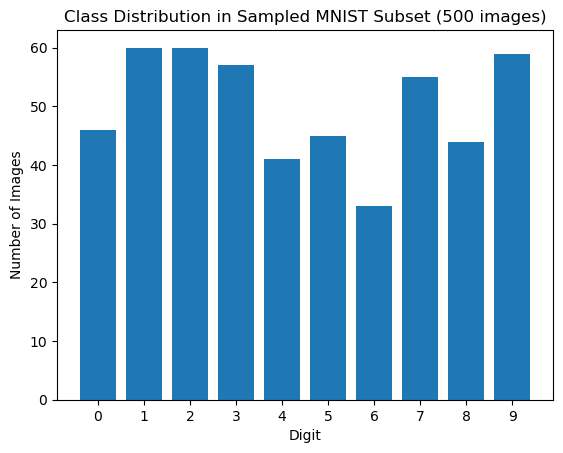

In [4]:
sampled_labels = [sampled_test_data[i][1] for i in range(len(sampled_test_data))]
label_counts = Counter(sampled_labels)

for label in sorted(label_counts):
    print(f"Label {label}: {label_counts[label]} images")

plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Digit')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Sampled MNIST Subset (500 images)')
plt.xticks(range(10))
plt.show()

In [11]:
# from scipy.stats import gaussian_kde


# matrixG = imgcalc.get_matrixG(testSample, imageProductType)
# upper_triangle = matrixG[np.triu_indices_from(matrixG, k=0)]

# mean_val = np.mean(upper_triangle)
# density = gaussian_kde(upper_triangle)
# x_vals = np.linspace(min(upper_triangle), max(upper_triangle), 500)
# density_vals = density(x_vals)
# plt.hist(upper_triangle, bins='auto', edgecolor='black', density=True, alpha=0.6, label='Histogram')
# plt.plot(x_vals, density_vals, color='blue', linewidth=2, label='Density Curve')
# plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean_val:.2f}')
# plt.title("Distribution of NCC Scores in MNIST Test Set")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

In [34]:
import src.data_processing.ImageCalculations as imgcalc
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.MetricUtilities as metrics
%reload_ext autoreload

%autoreload 2

In [33]:
# random testing for metric
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.MetricUtilities as metrics


index = np.random.randint(len(testSample))
input1 = input_dataset[index][0].squeeze().to('cpu').numpy()
index = np.random.randint(len(testSample))
input2 = input_dataset[index][0].squeeze().to('cpu').numpy()
index = np.random.randint(len(testSample))
input3 = input_dataset[index][0].squeeze().to('cpu').numpy()

for i in range(1000):
    dist1 = metrics.distance(input1, input3)
    dist2 = metrics.distance(input1, input2)
    dist3 = metrics.distance(input2, input3)
    if (dist1 > dist2 + dist3):
        print("WE FAILED")
        imgplt.plot_original_images(input1, input2, index, index)
        imgplt.plot_original_images(input2, input3, index, index)
        print((dist1, dist2, dist3))
    index = np.random.randint(len(testSample))
    input1 = input2
    input2 = input3
    input3 = input_dataset[index][0].squeeze().to('cpu').numpy()

In [14]:
matrixG = imgcalc.get_matrixG(testSample, "ncc")
print(matrixG)

[[1.         0.77062237 0.77306217 ... 0.7857399  0.77486873 0.75619906]
 [0.77062237 1.         0.80142546 ... 0.94857055 0.86316425 0.81493616]
 [0.77306217 0.80142546 1.         ... 0.83386266 0.79865223 0.81667954]
 ...
 [0.7857399  0.94857055 0.83386266 ... 1.         0.853854   0.84523278]
 [0.77486873 0.86316425 0.79865223 ... 0.853854   1.         0.77381521]
 [0.75619906 0.81493616 0.81667954 ... 0.84523278 0.77381521 1.        ]]


In [15]:
print(matrixG)

dist_vec = metrics.getDistance(matrixG[0])
G_prime = metrics.getDistanceMatrix(matrixG)
print(G_prime)
#print(G_prime[0])
#print("DIST VEC")
#print(dist_vec)
#print(dist_vec.shape)

[[1.         0.77062237 0.77306217 ... 0.7857399  0.77486873 0.75619906]
 [0.77062237 1.         0.80142546 ... 0.94857055 0.86316425 0.81493616]
 [0.77306217 0.80142546 1.         ... 0.83386266 0.79865223 0.81667954]
 ...
 [0.7857399  0.94857055 0.83386266 ... 1.         0.853854   0.84523278]
 [0.77486873 0.86316425 0.79865223 ... 0.853854   1.         0.77381521]
 [0.75619906 0.81493616 0.81667954 ... 0.84523278 0.77381521 1.        ]]
[[0.         0.439891   0.4374481  ... 0.42456487 0.43563186 0.45410831]
 [0.439891   0.         0.40815067 ... 0.20505963 0.33695842 0.39354389]
 [0.4374481  0.40815067 0.         ... 0.37224893 0.41109342 0.39162477]
 ...
 [0.42456487 0.20505963 0.37224893 ... 0.         0.34851823 0.3589235 ]
 [0.43563186 0.33695842 0.41109342 ... 0.34851823 0.         0.43669179]
 [0.45410831 0.39354389 0.39162477 ... 0.3589235  0.43669179 0.        ]]


In [ ]:
from mtree.mtree import MTree
import mtree.mtree as mtree

# Omg it's cooking and it's q fast too hehe

def tree_len(tree):
    """Count the number of element in a tree by inspecting the nodes"""
    def node_len(node):
        if isinstance(node, mtree.InternalNode):
            return sum(node_len(e.subtree) for e in node.entries)
        else:
            return len(node.entries)
    return node_len(tree.root)

# Note it can only find up to max_node_size nearest neighbors...
tree = MTree(metrics.distance, max_node_size=5)
#testSamples = mnist_test_dataload()
tree.add_all(testSample)
#print(tree_len(tree))
test_img = testSample[0]
k = 5
l = tree.search(test_img, k)
#print(metrics.distance(testSample[0], testSample[0]))
imgs = list(l)
#print(imgs)

#imgplt.plot_original_images(list(l)[0], testSample[0], 10, 0)


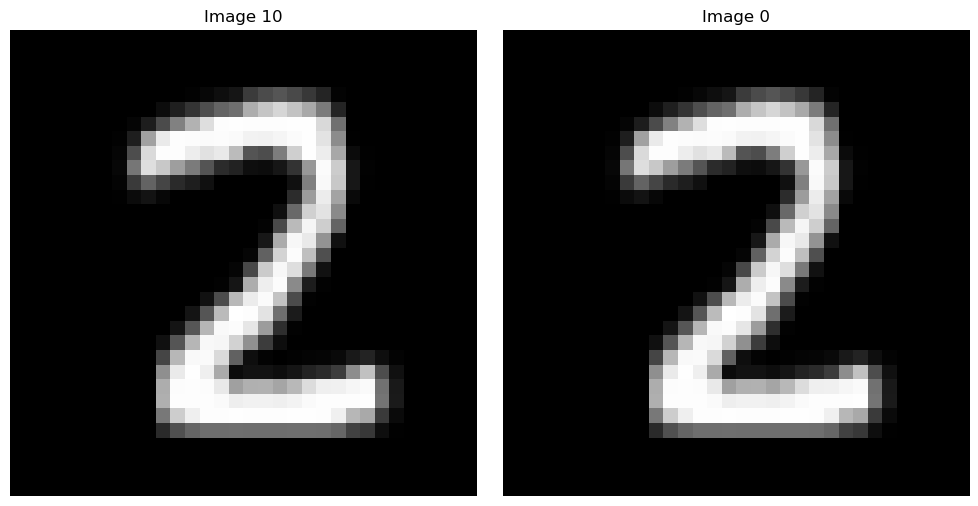

0.0


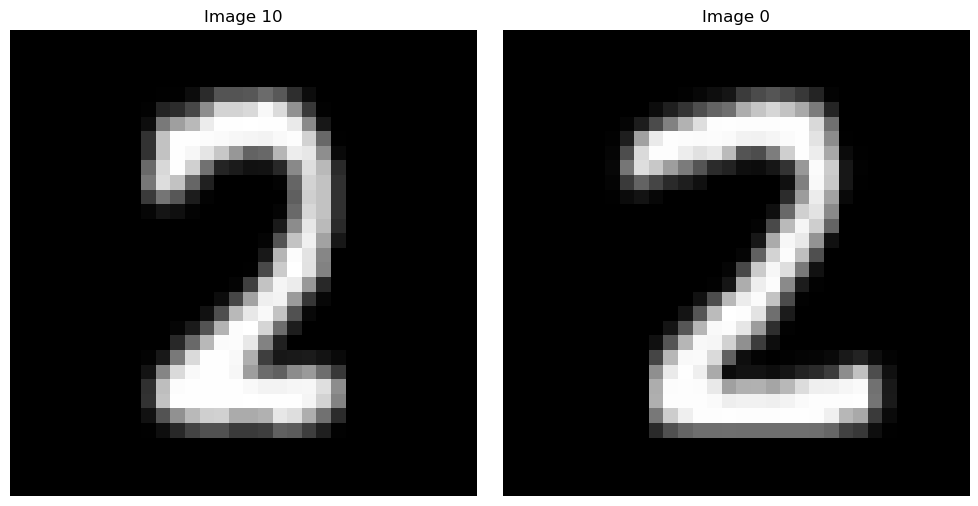

0.20832156585813433


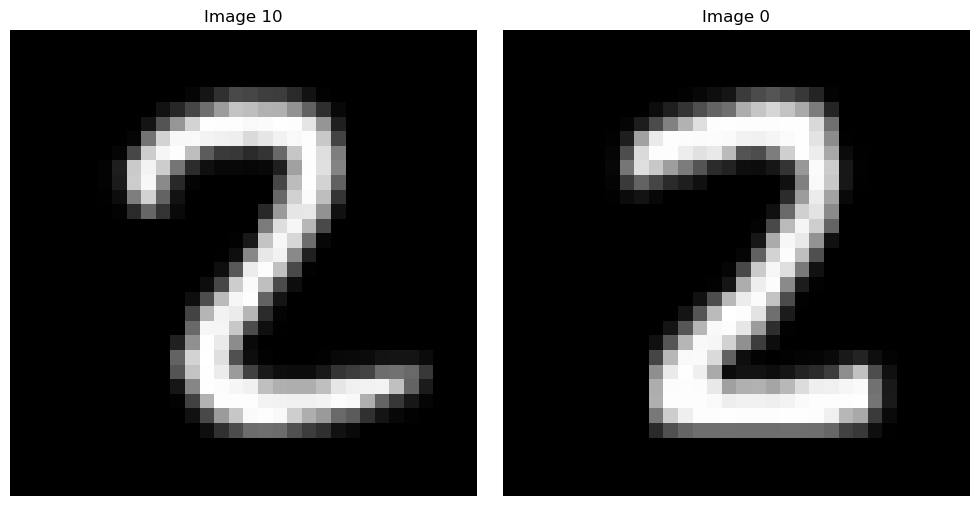

0.21287737406594653


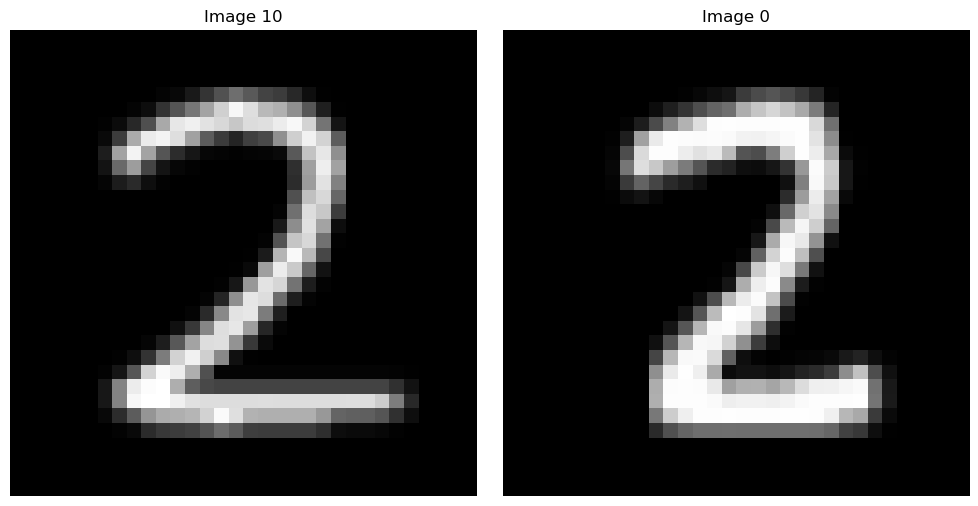

0.23304404203433854


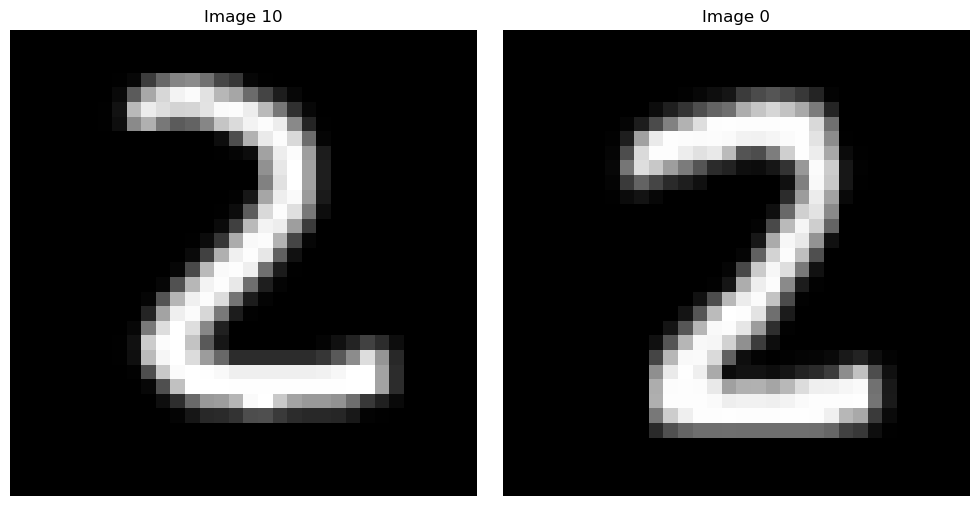

0.23647709939503067


In [56]:
for i in range(k):
    if (imgs[i] is not None):
        imgplt.plot_original_images(imgs[i], testSample[0], 10, 0)
        print(metrics.distance(imgs[i], testSample[0]))

# Visualiation and Calculation using 2 random inputs

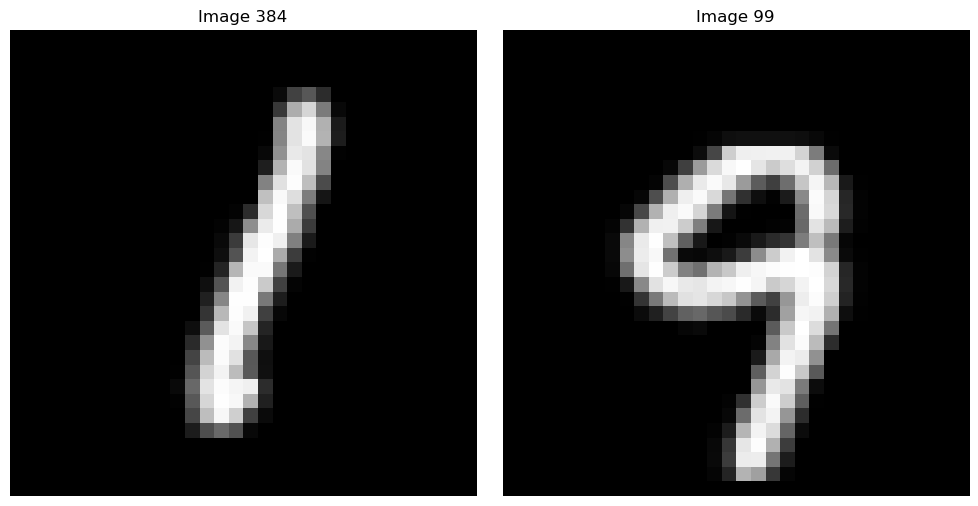

In [11]:

# index1 = np.random.randint(len(testSample))
# index2 = np.random.randint(len(testSample))
# input1=torch.from_numpy(testSample[index1]).squeeze()
# input2=torch.from_numpy(testSample[index2]).squeeze()

# imgplt.plot_original_images(input1, input2, index1, index2)

# # ------------------------- Preprocessing Dataset ------------------------
# input_dataset = [
#     torch.from_numpy(testSample[i]).unsqueeze(0).unsqueeze(0).to(device).double()  #numpy -> tensor
#     for i in range(len(testSample))
# ]

# stacked_tensor = torch.stack(input_dataset)             
# input_dataset = stacked_tensor.cpu().numpy()             
# input_dataset = [torch.tensor(img).to(device).float() for img in input_dataset] 
# 


index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
input1=input_dataset[index1][0].squeeze().to('cpu')
input2=input_dataset[index2][0].squeeze().to('cpu')

imgplt.plot_original_images(input1.numpy(), input2.numpy(), index1, index2)


# test1 = np.array([[-1,-1,-1,-1], 
#                   [-1,-0.95,-0.93,-1],
#                   [-1,-0.9,-0.88,-1],
#                   [-1,-1,-1,0.5]])

# test2 = np.array([[-1,-1,-1,-1], 
#                   [-1,0.5,0.47,-1],
#                   [-1,0.44,0.43,-1],
#                   [-1,-1,-1,0.5]])

# test3 = np.array([[-0.95,-0.93,-1,-1], 
#                   [-0.9,-0.88,-1,-1],
#                   [-1,-1,0.5,0.47],
#                   [-1,-1,0.44,0.43]])
# i = 0
# j = 1
# imgplt.plot_original_images(test1, test2, i, j)
# imgplt.plot_original_images(test2, test3, i, j)

# import src.data_processing.ImageProducts as ImageProducts

# print(ImageProducts.ncc(test1, test2))
# print(ImageProducts.ncc(test2, test3))
# print(ImageProducts.ncc(test1, test3))


# dist1 = metrics.distance(test1, test3)
# dist2 = metrics.distance(test1, test2)
# dist3 = metrics.distance(test2, test3)

# if (dist1 > dist2 + dist3):
#     print("WE FAILED")
#     #imgplt.plot_original_images(input1, input2, index, index)
#     #imgplt.plot_original_images(input2, input3, index, index)
#     print((dist1, dist2, dist3))

In [62]:
model = models.SimpleCNN4(dimensions=dimensions, padding_mode='circular').to(device)
dimensions = 128
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../"), model_directory, 
                                              f'best_model_MNIST_{imageType}_{dimensions}d_convlayer3_SimpleCNN4_CBAM_dropout.pt'), weights_only=True, map_location=torch.device('cpu')), strict=False)
model.eval()

# dimensions = 128
# model = tcnnmodels.CircleLayers2(0.5, dimensions=dimensions, padding_mode='circular').to(device)
# model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
#                                                f'best_model_MNIST_{imageType}_{dimensions}d_convlayer3_CircleLayers2.pt'), weights_only=True, map_location=device), strict=False)
# model.eval()

# model = tcnnmodels.KleinLayers2(2, dimensions=dimensions, padding_mode='circular').to(device)
# dimensions = 128
# model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
#                                                f'best_model_MNIST_{imageType}_{dimensions}d_convlayer3_KleinLayers2.pt'), weights_only=True, map_location=torch.device('cpu')), strict=False)
# model.eval()




SimpleCNN4(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd1): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd2): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=c

In [63]:
import src.data_processing.ImageCalculations as imgcalc
%reload_ext autoreload

%autoreload 2

In [64]:

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
print(matrixG)
# Why is my matrix A not deterministic UHM
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(matrixA)
dot_product_matrix = matrixA.T @ matrixA
print(dot_product_matrix)
# other_dot_product_matrix = np.dot(matrixA.T, matrixA)
# print(other_dot_product_matrix)

[[1.         0.54124475 0.54612434 ... 0.5714798  0.54973745 0.51239812]
 [0.54124475 1.         0.60285091 ... 0.8971411  0.72632849 0.62987232]
 [0.54612434 0.60285091 1.         ... 0.66772532 0.59730446 0.63335907]
 ...
 [0.5714798  0.8971411  0.66772532 ... 1.         0.707708   0.69046557]
 [0.54973745 0.72632849 0.59730446 ... 0.707708   1.         0.54763043]
 [0.51239812 0.62987232 0.63335907 ... 0.69046557 0.54763043 1.        ]]
[[ 7.62528487e-01  8.45648883e-01  7.65108752e-01 ...  8.77449799e-01
   8.01426419e-01  7.70271689e-01]
 [ 5.73130635e-02 -2.27424928e-01  1.02168819e-01 ... -3.14057676e-01
   8.40154780e-02  1.37337799e-02]
 [-4.27991889e-02  6.01770368e-02 -2.58762627e-01 ... -1.61504600e-02
  -2.18360844e-01 -1.16068409e-01]
 ...
 [ 0.00000000e+00 -6.47867956e-10 -9.36989934e-10 ...  2.10068575e-09
  -2.70749058e-10  8.73292516e-10]
 [ 0.00000000e+00 -1.75672961e-10 -3.91596186e-11 ... -6.31044075e-09
  -4.29693214e-09 -4.55670961e-09]
 [ 0.00000000e+00 -8.91871

In [ ]:
# # Why is my matrix A not deterministic UHM
print("FIRST MATRIX A")
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(matrixA)

print("SECOND MATRIX A")
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(matrixA)

### Visualisation of Loss score calculation -- Metric 1

In [53]:
# #----------------------Metric 1 - Loss Calculation-----------------
# NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
# print("\nLoss Calculation")
# print("\nScaled NCC: ",NCC_scaled_value)

# matrixG = imgcalc.get_matrixG(testSample, imageProductType)
# matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

# model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
# #model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
# #model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

# dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

# print("\nDot product value of model embeddings: ", dot_product_value.item())

# train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
# print("Loss: ", train_loss_value)

# #dot_product_value = imgcalc.get_dp_score(model_transformed[index1], model_transformed[index2])

# print("\nDot product value of model transformed embeddings: ", dot_product_value.item())

# train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
# print("Loss: ", train_loss_value)

# #input1_transformed_normalised =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# #input2_transformed_normalised =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
# #dot_product_value = imgcalc.get_dp_score(input1_transformed_normalised, input2_transformed_normalised)

# #print("\nDot product value of model transformed normalised embeddings: ", dot_product_value.item())

# train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
# print("Loss: ", train_loss_value)

# dot_product_matrix = np.dot(matrixA.T, matrixA)
# dot_product_value_Pencorr = dot_product_matrix[index1][index2]
# difference = abs(dot_product_value_Pencorr - dot_product_value)

# print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

# train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
# print("Loss: ", train_loss_value)
# print("\nDifference in values of BF Method and Model Method: ", difference.item())

#----------------------Metric 1 - Loss Calculation-----------------
import src.data_processing.ImageCalculations as imgcalc
%reload_ext autoreload

%autoreload 2

NCC_scaled_value = imgcalc.get_NCC_score(input1.numpy(), input2.numpy())
#print(matrixG[index1][index2])
print("\nLoss Calculation")
print("\nScaled NCC: ", NCC_scaled_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
# model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
# model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

print("\nDot product value of model embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

# dot_product_value = imgcalc.get_dp_score(model_transformed[index1], model_transformed[index2])

print("\nDot product value of model transformed embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

# input1_transformed_normalised =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# input2_transformed_normalised =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
# dot_product_value = imgcalc.get_dp_score(input1_transformed_normalised, input2_transformed_normalised)

print("\nDot product value of model transformed normalised embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

# dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_matrix = matrixA.T @ matrixA
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("\nDifference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.5427107810974121

Dot product value of model embeddings:  0.4707527160644531
Loss:  0.07195806503295898

Dot product value of model transformed embeddings:  0.4707527160644531
Loss:  0.07195806503295898

Dot product value of model transformed normalised embeddings:  0.4707527160644531
Loss:  0.07195806503295898

Dot product value of BF Method embeddings:  0.5435927627149868
Loss:  0.0008819699287414551

Difference in values of BF Method and Model Method:  0.07284003496170044


In [ ]:
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

In [59]:
# WRITE CODE TO GET OUT AVERAGE K-SCORE OVER A BUNCHA DIFF IMAGES.

n = 1000
k_score_total_brute = 0
k_score_total_model = 0

for i in range(n):
    index1 = np.random.randint(len(testSample))
    input1=input_dataset[index1][0].squeeze().to('cpu')
    
    vectorb_bf1 = matrixG[index1]
    vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
    kscore, indices, intersection_indices = imgcalc.get_kscore_and_sets(vectorb_bf1, vectorc_bf1, k)
    k_score_total_brute += kscore

    vectorb_model1 = matrixG[index1]
    vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
    kscore, indices, intersection_indices = imgcalc.get_kscore_and_sets(vectorb_model1, vectorc_model1, k)
    k_score_total_model += kscore

print("Brute Force k-score average over {} images: {}".format(n, k_score_total_brute / n))
print("Model k-score average over {} images: {}".format(n, k_score_total_model / n))

    

Brute Force k-score average over 1000 images: 0.8117818181818283
Model k-score average over 1000 images: 0.21431439671439542


### Visualisation of KNN-IoU K score calculation -- Metric 2

----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 139: K-Score = 0.7777777777777778
Intersection sets : [ 15  45  85 139 264 467 499]
Union sets: [ 15  45  85 139 155 235 264 467 499]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   139                    1.000000                            1.000000
    15                    0.741660                            0.748314
    45                    0.745429                            0.753700
    85                    0.778811                            0.802815
   155                    0.736284                            0.725454
   235                    0.726469                            0.737356
   264                    0.778334                            0.784424
   467                    0.734277                            0.729584
   499                    0.748761                            0.755868

Comparing imag

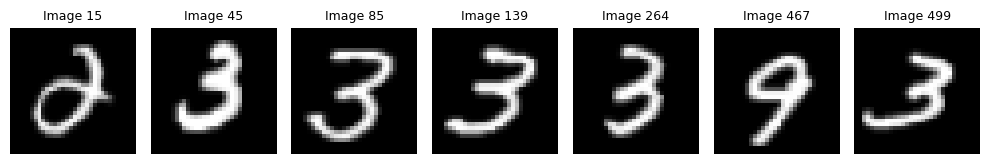


Plotting images in the union set:


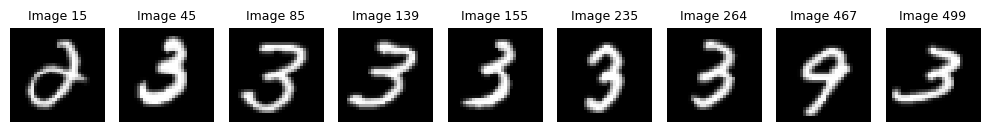


For translationally unique plots: 
Image 15 has no translationally similar images.
Image 45 has no translationally similar images.
Image 85 has no translationally similar images.
Image 139 has no translationally similar images.
Image 155 has no translationally similar images.
Image 235 has no translationally similar images.
Image 264 has no translationally similar images.
Image 467 has no translationally similar images.
Image 499 has no translationally similar images.

Plotting images in the intersection set:


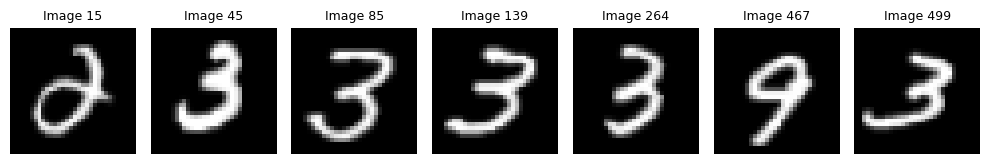


Plotting images in the union set:


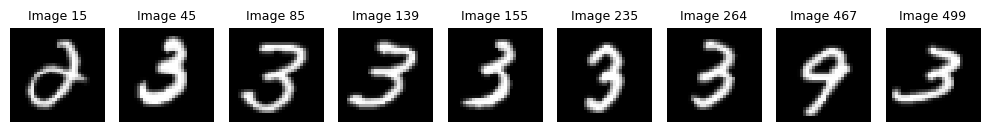


Top 9 values of Vector b
Rank 1: Value = 1.0, Index = 139
Rank 2: Value = 0.7788112163543701, Index = 85
Rank 3: Value = 0.778334379196167, Index = 264
Rank 4: Value = 0.7487611770629883, Index = 499
Rank 5: Value = 0.7454285621643066, Index = 45
Rank 6: Value = 0.7416596412658691, Index = 15
Rank 7: Value = 0.7362840175628662, Index = 155
Rank 8: Value = 0.7342770099639893, Index = 467
Rank 9: Value = 0.7289226055145264, Index = 377

Top 9 values of Vector c
Rank 1: Value = 1.0000000000000016, Index = 139
Rank 2: Value = 0.8028146684163593, Index = 85
Rank 3: Value = 0.7844239448684127, Index = 264
Rank 4: Value = 0.755867505316559, Index = 499
Rank 5: Value = 0.7536995228086457, Index = 45
Rank 6: Value = 0.7483142180432751, Index = 15
Rank 7: Value = 0.7373560931805682, Index = 235
Rank 8: Value = 0.7295839109954237, Index = 467
Rank 9: Value = 0.7254539716374777, Index = 155

Bottom 9 values of Vector b
Rank 1: Value = 0.12056994438171387, Index = 372
Rank 2: Value = 0.15706694126

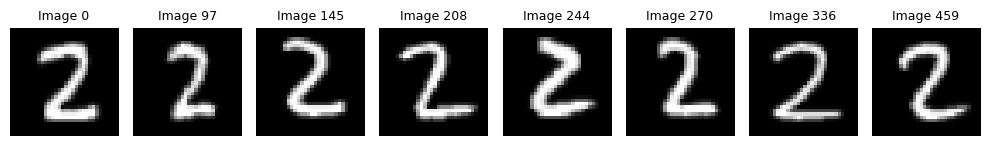


Plotting images in the union set:


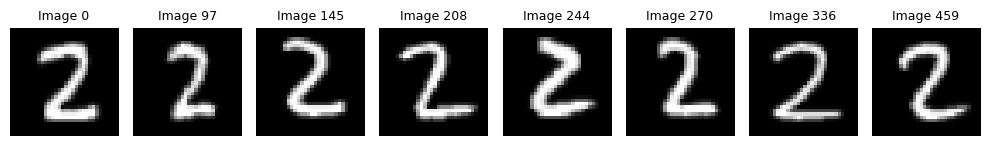


For translationally unique plots: 
Image 0 has no translationally similar images.
Image 97 has no translationally similar images.
Image 145 has no translationally similar images.
Image 208 has no translationally similar images.
Image 244 has no translationally similar images.
Image 270 has no translationally similar images.
Image 336 has no translationally similar images.
Image 459 has no translationally similar images.

Plotting images in the intersection set:


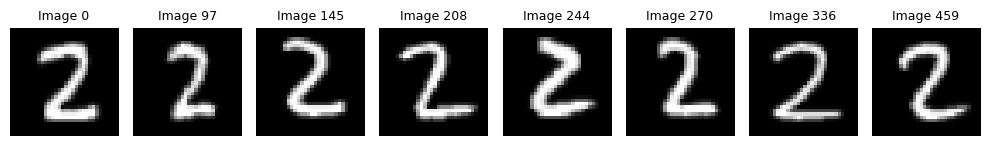


Plotting images in the union set:


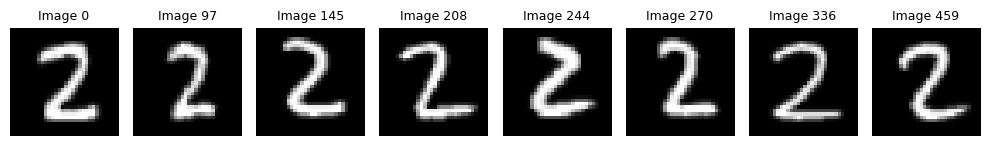


Top 9 values of Vector b
Rank 1: Value = 1.0, Index = 145
Rank 2: Value = 0.9126180410385132, Index = 270
Rank 3: Value = 0.8952114582061768, Index = 459
Rank 4: Value = 0.8751981258392334, Index = 208
Rank 5: Value = 0.8732701539993286, Index = 244
Rank 6: Value = 0.8635987043380737, Index = 0
Rank 7: Value = 0.833478569984436, Index = 336
Rank 8: Value = 0.8317432403564453, Index = 97
Rank 9: Value = 0.8258836269378662, Index = 397

Top 9 values of Vector c
Rank 1: Value = 1.0000000000000009, Index = 145
Rank 2: Value = 0.9189299988839205, Index = 270
Rank 3: Value = 0.8908643914469754, Index = 244
Rank 4: Value = 0.8877427678626725, Index = 459
Rank 5: Value = 0.8768260869457226, Index = 208
Rank 6: Value = 0.868126221689024, Index = 0
Rank 7: Value = 0.8264198254690164, Index = 336
Rank 8: Value = 0.8212340454960183, Index = 97
Rank 9: Value = 0.8001608956698498, Index = 397

Bottom 9 values of Vector b
Rank 1: Value = 0.23362791538238525, Index = 372
Rank 2: Value = 0.24549007415

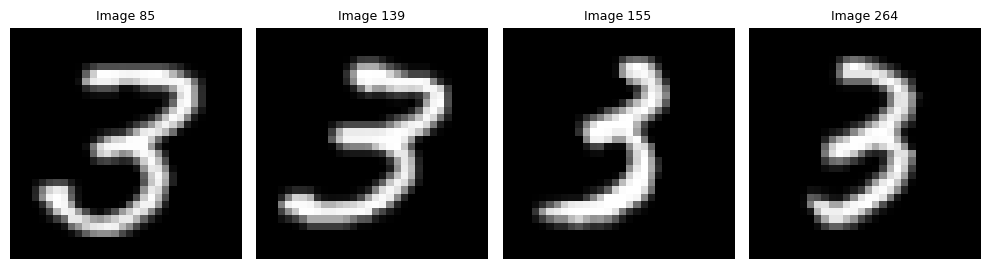


Plotting images in the union set:


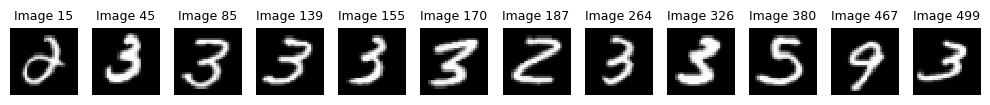


For translationally unique plots: 
Image 15 has no translationally similar images.
Image 45 has no translationally similar images.
Image 85 has no translationally similar images.
Image 139 has no translationally similar images.
Image 155 has no translationally similar images.
Image 170 has no translationally similar images.
Image 187 has no translationally similar images.
Image 264 has no translationally similar images.
Image 326 has no translationally similar images.
Image 380 has no translationally similar images.
Image 467 has no translationally similar images.
Image 499 has no translationally similar images.

Plotting images in the intersection set:


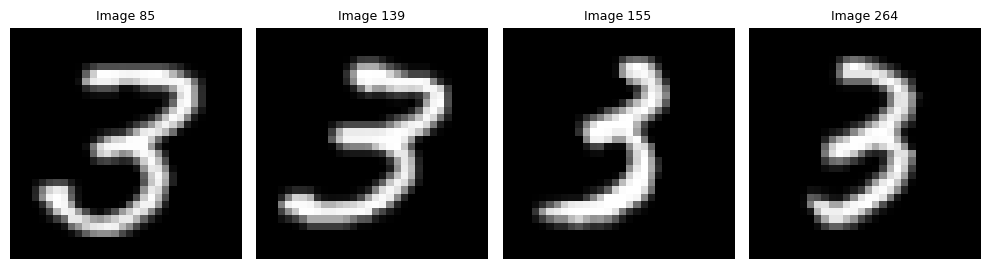


Plotting images in the union set:


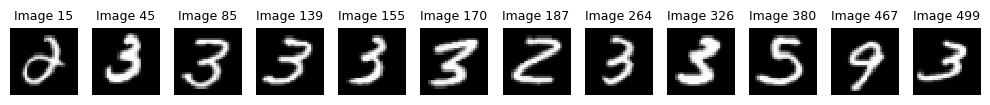

Estimating K-Score for Image 145: K-Score = 0.6
Intersection sets : [  0  97 145 244 270 459]
Union sets: [  0  65  97 143 145 208 244 270 336 459]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   145                    1.000000                            1.000000
     0                    0.863599                            0.902660
    65                    0.742568                            0.867779
    97                    0.831743                            0.893098
   143                    0.704338                            0.873968
   208                    0.875198                            0.735600
   244                    0.873270                            0.953301
   270                    0.912618                            0.885540
   336                    0.833479                            0.801595
   459                    0.895211                            0.895186

Comparing images in intersec

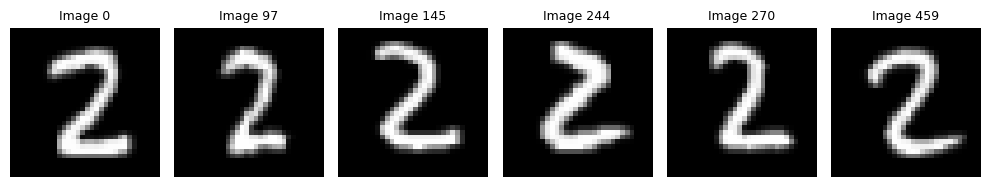


Plotting images in the union set:


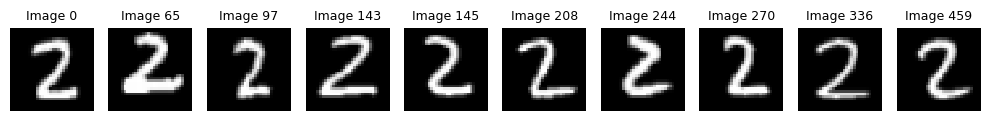


For translationally unique plots: 
Image 0 has no translationally similar images.
Image 65 has no translationally similar images.
Image 97 has no translationally similar images.
Image 143 has no translationally similar images.
Image 145 has no translationally similar images.
Image 208 has no translationally similar images.
Image 244 has no translationally similar images.
Image 270 has no translationally similar images.
Image 336 has no translationally similar images.
Image 459 has no translationally similar images.

Plotting images in the intersection set:


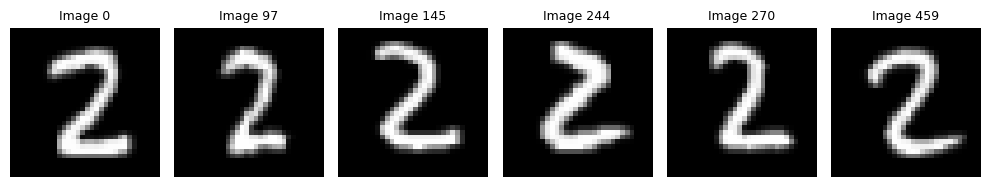


Plotting images in the union set:


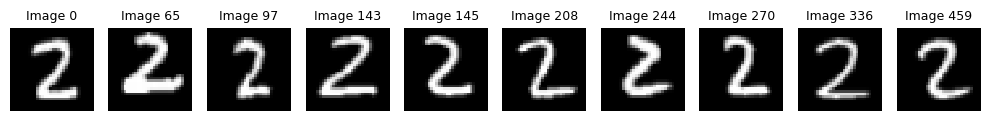

----------------
Transformed Model Method -- KNN-IOU score
----------------


NameError: name 'model_transformed' is not defined

In [ ]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)
kscore, indices, intersection_indices = metrics.get_k_neighbour_score(vectorb_bf1, vectorc_bf1, k)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)

print("----------------\nTransformed Model Method -- KNN-IOU score\n----------------")
input2_transformed_1 =  model_transformed[index1]
input2_transformed_2 =  model_transformed[index2]
vectorc_transformed_1 = []
vectorc_transformed_2 = []
for j in range(len(input_dataset)):
    input1_transformed =  model_transformed[j]
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_1, dim=1)
    vectorc_transformed_1.append(dot_product_transformed.detach().cpu().numpy().item())
    
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_2, dim=1)
    vectorc_transformed_2.append(dot_product_transformed.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_2, "Model", index2, k, testSample)

print("----------------\nTransformed Normalised Model Method -- KNN-IOU score\n----------------")
input2_transformed_normalised_1 =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised_2 =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
vectorc_transformed_normalised_1 = []
vectorc_transformed_normalised_2 = []
for j in range(len(input_dataset)):
    input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_1, dim=1)
    vectorc_transformed_normalised_1.append(dot_product_transformed_normalised.detach().cpu().numpy().item())
    
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_2, dim=1)
    vectorc_transformed_normalised_2.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_normalised_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_normalised_2, "Model", index2, k, testSample)

### Visualisation of Relative Squared Difference of **original** matrix and vector embedding -- Metric 3

In [ ]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

# model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
# model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
#                  f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Matrices -- Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of of Matrices -- Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of of Matrices -- Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed** matrix and vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Matrices -- Transformed Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Matrices -- Transformed Model and Pencorr (A'A):", mean_squared_difference)

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Transformed Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed normalised** vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After normalising the transformed output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Normalised Model: {model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], (model_transformed[index1].detach().numpy()/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())))
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Normalised Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of original vector embeddings of similar images across dimensions -- Metric 4

In [ ]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

### Visualisation of original vector embeddings of different images across dimensions -- Metric 4

In [ ]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

# Visualiation and Calculation across dataset, across dimensions

## Metric 1 & 2: Loss and K-Score
### Visualisation of loss and k-score across dataset across dimensions

In [ ]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
dimensions = [128]
losses_transformed_normalised = []
losses_transformed = []
losses_original = []
kscores_transformed_normalised = []
kscores_transformed = []
kscores_original = []
losses_BFMethod = []
kscores_BFMethod = []

input_dataset = []
testSample = []
num = len(sampled_test_data)
for i in range(len(sampled_test_data)):
    img_tensor = sampled_test_data[i][0] 
    input_dataset.append(img_tensor.unsqueeze(0).to(device).float())
    img_numpy = img_tensor.squeeze().cpu().numpy().astype(np.float32)
    testSample.append(img_numpy)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions: 
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN4_CBAM_2fc(dimensions=dim, padding_mode='circular').to(device)
    
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer3_SimpleCNN4_CBAM_2fc.pt'), weights_only=True, map_location=torch.device('cpu')))
    
#     checkpoint_path = os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
#                          f'best_MNIST_model_classification_SimpleCNN4_CBAM_2fc_64d.pt')
#     state_dict = torch.load(checkpoint_path, map_location='cpu')
#     filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier.")}
#     model.load_state_dict(filtered_state_dict, strict=False)

    model.eval()

    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

    kscore_transformed_normalised = []
    kscore_transformed = []
    kscore_original = []
    
    loss_original = []
    loss_transformed = []
    loss_transformed_normalised = []
    
    for i in range(num):
        vectorb = imgcalc.get_vectorb(i, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        #since after transformation, its not a unit vector
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            #since after transformation, its not a unit vector
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())

            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)

            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])

            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
            
    kscore_BFMethod, loss_BFMethod, _ = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)
    
    imgplt.plot_score_distribution(loss_BFMethod, "Loss BFMethod")
    imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
    imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
    imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
    imgplt.plot_score_distribution(kscore_BFMethod, "K-Score BFMethod")
    imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
    imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
    imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")
    
    losses_transformed_normalised.append(np.mean(loss_transformed_normalised))
    losses_transformed.append(np.mean(loss_transformed))
    losses_original.append(np.mean(loss_original))
    losses_BFMethod.append(np.mean(loss_BFMethod))
    kscores_transformed_normalised.append(np.mean(kscore_transformed_normalised))
    kscores_transformed.append(np.mean(kscore_transformed))
    kscores_original.append(np.mean(kscore_original))
    kscores_BFMethod.append(np.mean(kscore_BFMethod))
    
    #0.058 0.420 CNN4_CBAM_2fc 0.650 0.211 Weight Exchange

In [ ]:
print(f"BFMethod: Loss and Kscores")
print("Kscores: ",kscores_BFMethod, np.argmax(kscores_BFMethod))
print("Losses: ",losses_BFMethod, np.argmin(losses_BFMethod))

print(f"\nOriginal Model: Loss and Kscores")
print("Kscores: ",kscores_original, np.argmax(kscores_original))
print("Losses: ",losses_original, np.argmin(losses_original))

print(f"\nTransformed Model: Loss and Kscores")
print("Kscores: ",kscores_transformed, np.argmax(kscores_transformed))
print("Losses: ",losses_transformed, np.argmin(losses_transformed))

print(f"\nTransformed Normalized Model: Loss and Kscores")
print("Kscores: ",kscores_transformed_normalised, np.argmax(kscores_transformed_normalised))
print("Losses: ",losses_transformed_normalised, np.argmin(losses_transformed_normalised))

## Metric 3: Relative Squared Difference between vector embeddings
### Visualisation of Relative Squared Difference between vector embeddings, of original and transformed model using Orthogonal Procrustes, and Pencorr embeddings across dataset across dimensions

In [ ]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed_normalised = []
MSD_transformed = []
MSD_original = []
dimensions = [32, 64, 128, 256, 512]    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    # find a fair way to compare across the dimensions,
        # maybe can experiment with the different angles \
    MSE_transformed_normalised = []
    MSE_transformed = []
    MSE_original = []
    
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Models:")   
    for i in range(num):
        normalized_embedding = (model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())).detach().cpu().numpy()
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], normalized_embedding)
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed_normalised.append(mean_squared_difference)
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_transformed_normalised.append(np.mean(MSE_transformed_normalised))                                              
    MSD_transformed.append(np.mean(MSE_transformed))
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_transformed_normalised, f"MSE of Transformed Normalised Model")                                              
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [ ]:
print("RSD Original Model: ", MSD_original, np.argmin(MSD_original))
print("RSD Transformed Model: ", MSD_transformed, np.argmin(MSD_transformed))
print("RSD Transformed Normalised Model: ", MSD_transformed_normalised, np.argmin(MSD_transformed_normalised))

## Metric 4: F1 Score
### Calculation of F1 Score across dimension using original vector embeddings and Pencorr embeddings

In [ ]:
#For model method F1 score calculation per dimension K
dimensions = [32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    # model = models.SimpleCNN6(dimensions=dim, padding_mode='circular').to(device)
    # model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
    #                  f'best_model_MNIST_{imageType}_{dim}d_convlayer5.pt'), weights_only=True, map_location=torch.device('cpu')))

    model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    #matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(model_vectors[i].detach().cpu().numpy(), model_vectors[j].detach().cpu().numpy())
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

In [ ]:
#For BFMEthod F1 score calculation per dimension K
dimensions = [32, 64, 128, 256, 512]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    # model = models.SimpleCNN3(dimensions=dim, padding_mode='circular').to(device)
    # model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
    #                  f'best_model_{imageType}_{dim}d_convlayer2.pt'), weights_only=True, map_location=torch.device('cpu')))

    # model.eval()
    f1_index = []
    
    tp_index = []
    fp_index = []
    tn_index = []
    fn_index = []
    #model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,i], matrixA[:,top_1_index])
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], matrixA[:,j])
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        tp_index.append(TP)
        fp_index.append(FP)
        tn_index.append(TN)
        fn_index.append(FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)

    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(np.mean(tp_index), np.mean(fp_index), np.mean(tn_index), np.mean(fn_index))
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")

# Obtaining the optimal dimension using 4 different metrics above

In [ ]:
from collections import Counter
dimensions = [32, 64, 128, 256, 512]


metric1 = np.argmax(kscores_original)
metric2 = np.argmin(losses_original)
metric3A = np.argmin(MSD_original)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

### Using normalized embedding validation loss to determine optimal dimension.
#### Existing strategies for the selection of the embedding dimension rely on performance maximization in downstream tasks.

In [ ]:
def find_optimal_dim(losses, eps=0.05):  
    """
    Finds the optimal dimension based on the embedding loss function.

    :param losses: Dictionary {dimension: loss value}
    :param eps: Threshold percentage (default 0.05)
    :return: The optimal dimension
    """
    L_inf = min(losses.values())

    for d in sorted(losses.keys()): 
        if L_inf == 0 or (losses[d] - L_inf) / L_inf <= eps:  
            return d  

    return max(losses.keys()) 

losses = {8: 0.17436, 16: 0.10059, 32: 0.08990, 64: 0.09155, 128: 0.09328, 256: 0.0636}
optimal_dim = find_optimal_dim(losses)
print("Optimal Dimension:", optimal_dim)

In [ ]:
# -------------- for debugging -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)